# Model Selection

compare the machine learning results of a <b>support vector machine</b> (SVC) of sklearn and the <b>sklearn_crfsuite</b> model, which is especially designed to learn the sequence of labels. <br>

In [1]:
import nltk
import pandas as pd
import numpy as np
import scipy as sp
import sklearn
from scipy import sparse
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [2]:
from evaluation import get_all_labels, get_classify_report, get_recognition_report, get_confusion_matrix

In [3]:
sparse_train = sp.sparse.load_npz('transitional_data/X5_train.npz')
sparse_dev = sp.sparse.load_npz('transitional_data/X5_dev.npz')

In [4]:
y_train = pd.read_csv("transitional_data/y_train.csv")
y_dev = pd.read_csv("transitional_data/y_dev.csv")

In [5]:
y_train = y_train.groupby(by = 'SentenceNR', group_keys=True).apply(lambda x: x)
y_train = y_train.rename(columns={"SentenceNR": "Sent", "Unnamed: 1": "TokenNr"})

In [6]:
y_dev = y_dev.groupby(by = 'SentenceNR', group_keys=True).apply(lambda x: x)
y_dev = y_dev.rename(columns={"SentenceNR": "Sent", "Unnamed: 1": "TokenNr"})

In [7]:
train_true = y_train["Label"]
dev_true = y_dev["Label"]

## Parameter fine tuning for the LinearSVC model

In [23]:
param_grid = {
    "penalty": ["l1", "l2"],
    "loss": ["hinge", "squared_hinge"],
    "class_weight": ["balanced", None],
}

In [24]:
svc = LinearSVC()

In [7]:
if False:
    %%time
    svc_gs = GridSearchCV(svc, param_grid, scoring = "f1_weighted", n_jobs = -1, refit='accuracy', cv=0, verbose=1 )
    svc_gs.fit(sparse_train, train_true)
    print(svc_gs.best_score_)
    print(svc_gs.best_params_)
    print(svc_gs.cv_results_)

In [29]:
regularization_grid1 = {
    "penalty": ["l2"],
    "loss": ["hinge"],
    "class_weight": [None],
    "C": [0.001, 0.01, 0.1, 1],
}

In [8]:
if False:
    %%time
    svc_gs = GridSearchCV(svc, regularization_grid1, scoring = "f1_weighted", n_jobs = -1, refit='accuracy', cv=5, verbose=1 )
    svc_gs.fit(sparse_train, train_true)
    print(svc_gs.best_score_)
    print(svc_gs.best_params_)
    print(svc_gs.cv_results_)

In [10]:
regularization_grid2 = {
    "penalty": ["l2"],
    "loss": ["hinge"],
    "class_weight": [None],
    "C": [0.2, 0.4, 0.6, 0.8, 1.0],
}

In [11]:
if False:
    %%time
    svc_gs = GridSearchCV(svc, regularization_grid2, scoring = "f1_weighted", n_jobs = -1, refit='accuracy', cv=5, verbose=1 )
    svc_gs.fit(sparse_train, train_true)
    print(svc_gs.best_score_)
    print(svc_gs.best_params_)
    print(svc_gs.cv_results_)

In [12]:
regularization_grid3 = {
    "penalty": ["l2"],
    "loss": ["hinge"],
    "class_weight": [None],
    "C": [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55],
}

In [13]:
if False:
    %%time
    svc_gs = GridSearchCV(svc, regularization_grid3, scoring = "f1_weighted", n_jobs = -1, refit='accuracy', cv=5, verbose=1 )
    svc_gs.fit(sparse_train, train_true)
    print(svc_gs.best_score_)
    print(svc_gs.best_params_)
    print(svc_gs.cv_results_)

## best paramter combination according to the GridSearchCV
#### {'C': 0.35, 'class_weight': None, 'loss': 'hinge', 'penalty': 'l2'}
weighed average f1 score of classifying: 93% <br>
weighed average f1 score of recognition: 67% <br>

In [24]:
svc = LinearSVC(C=0.35, class_weight=None, loss="hinge", penalty="l2")
%time svc.fit(sparse_train, train_true)

CPU times: user 40.9 s, sys: 230 ms, total: 41.1 s
Wall time: 41.2 s


/home/luxinyao/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=0.35, loss='hinge')

In [25]:
%%time
dev_pred = svc.predict(sparse_dev)

CPU times: user 44.7 ms, sys: 0 ns, total: 44.7 ms
Wall time: 43.9 ms


In [29]:
%time labels_pred = get_all_labels(dev_pred)
%time labels_true = get_all_labels(dev_true.tolist())

CPU times: user 16.3 ms, sys: 0 ns, total: 16.3 ms
Wall time: 16.3 ms
CPU times: user 88.1 ms, sys: 0 ns, total: 88.1 ms
Wall time: 88.6 ms


In [30]:
detected_true, valid_pred = get_classify_report(labels_true, labels_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.99      0.96      0.97        70
       COURT       0.99      1.00      1.00       130
        DATE       1.00      1.00      1.00       208
         GPE       0.97      0.97      0.97       128
       JUDGE       0.50      1.00      0.67         7
         ORG       0.81      0.83      0.82        58
OTHER_PERSON       0.88      0.81      0.84       217
  PETITIONER       0.30      0.38      0.33         8
   PRECEDENT       0.79      0.85      0.82        68
   PROVISION       0.99      1.00      1.00       197
  RESPONDENT       0.00      0.00      0.00         2
     STATUTE       0.99      0.99      0.99       180
     WITNESS       0.69      0.69      0.69        45

    accuracy                           0.93      1318
   macro avg       0.76      0.81      0.78      1318
weighted avg       0.93      0.93      0.93      1318



In [31]:
all_labels_compare = get_recognition_report(true = labels_true, pred = labels_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.58      0.55      0.57       121
       COURT       0.82      0.73      0.77       178
        DATE       0.90      0.94      0.92       222
         GPE       0.64      0.68      0.66       182
       JUDGE       0.32      0.88      0.47         8
         ORG       0.41      0.30      0.35       159
OTHER_PERSON       0.75      0.64      0.69       276
  PETITIONER       0.21      0.33      0.26         9
   PRECEDENT       0.37      0.33      0.35       177
   PROVISION       0.76      0.76      0.76       258
  RESPONDENT       0.00      0.00      0.00         5
     STATUTE       0.81      0.80      0.80       222
     WITNESS       0.48      0.53      0.50        58

   micro avg       0.68      0.65      0.67      1875
   macro avg       0.54      0.58      0.55      1875
weighted avg       0.68      0.65      0.67      1875



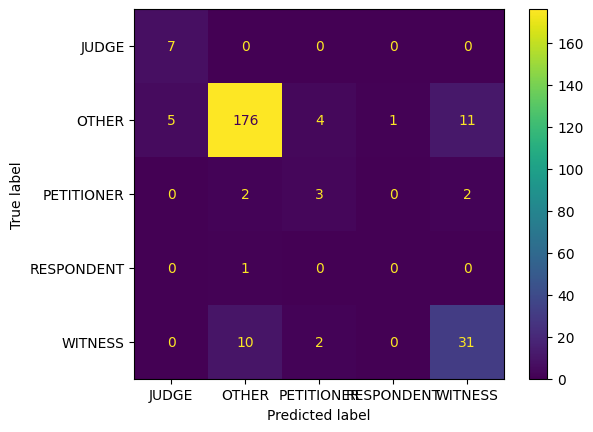

In [32]:
get_confusion_matrix(pred = all_labels_compare["pred"], true = all_labels_compare["true"], cat="natural_person")

## Problem: Feature Selection
Which features in the feature matrix make bigger contributions to the machine learning?

In [39]:
from sklearn.feature_selection import SelectFromModel
X, y = sparse_train, train_true
print(f"X.shape: {X.shape}")
lsvc_l1 = LinearSVC( penalty='l1', loss = "squared_hinge", dual = False, C = 0.35).fit(X, y)
lsvc_l2 = LinearSVC( penalty='l2', loss = "hinge", C = 0.35).fit(X, y)

X.shape: (349077, 71646)


/home/ccl/oj43ecpu/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [42]:
# L1 norm
model_l1 = SelectFromModel(lsvc_l1, prefit=True)
X_train_new = model_l1.transform(X)
X_dev_new = model_l1.transform(sparse_dev)
print(f"X_train_new.shape: {X_train_new.shape}")
print(f"X_dev_new.shape: {X_dev_new.shape}")

X_train_new.shape: (349077, 18550)
X_dev_new.shape: (37455, 18550)


In [43]:
# L2 norm
model_l2 = SelectFromModel(lsvc_l2, prefit=True)
X_train_new = model_l2.transform(X)
X_dev_new = model_l2.transform(sparse_dev)
print(f"X_train_new.shape: {X_train_new.shape}")
print(f"X_dev_new.shape: {X_dev_new.shape}")

X_train_new.shape: (349077, 25492)
X_dev_new.shape: (37455, 25492)


In [28]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
X_train, y_train = sparse_train, train_true
print(f"X_train.shape: {X_train.shape}")
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X, y)

X_train.shape: (349077, 71646)


In [30]:
clf.feature_importances_.shape

(71646,)

In [31]:
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_dev_new = model.transform(sparse_dev)
print(f"X_train_new.shape: {X_train_new.shape}")
print(f"X_dev_new.shape: {X_dev_new.shape}")

X_train_new.shape: (349077, 6983)
X_dev_new.shape: (37455, 6983)


In [32]:
%%time
dev_pred = clf.predict(sparse_dev)

CPU times: user 1.13 s, sys: 3 µs, total: 1.13 s
Wall time: 1.13 s


In [33]:
%time labels_pred = get_all_labels(dev_pred)
%time labels_true = get_all_labels(dev_true.tolist())

CPU times: user 5.58 ms, sys: 0 ns, total: 5.58 ms
Wall time: 5.29 ms
CPU times: user 5.59 ms, sys: 0 ns, total: 5.59 ms
Wall time: 5.5 ms


In [34]:
all_labels_compare = get_recognition_report(true = labels_true, pred = labels_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.58      0.37      0.45       121
       COURT       0.87      0.74      0.80       178
        DATE       0.92      0.83      0.87       222
         GPE       0.55      0.34      0.42       182
       JUDGE       0.45      0.62      0.53         8
         ORG       0.46      0.23      0.30       159
OTHER_PERSON       0.57      0.34      0.43       276
  PETITIONER       0.00      0.00      0.00         9
   PRECEDENT       0.28      0.21      0.24       177
   PROVISION       0.78      0.76      0.77       258
  RESPONDENT       0.00      0.00      0.00         5
     STATUTE       0.88      0.76      0.82       222
     WITNESS       0.29      0.16      0.20        58

   micro avg       0.69      0.52      0.59      1875
   macro avg       0.51      0.41      0.45      1875
weighted avg       0.65      0.52      0.57      1875



/home/ccl/oj43ecpu/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## sklearn_crfsuite Model
We will use the default feature matrix of the model. Details see below. <br>
<i>NB: This Model is only compatible only with a sklearn version lower as 0.24</i> <br>

weighed average f1 score of classifying: 95%  ( + 2% comparing to the svm model ) <br>
weighed average f1 score of recognition: 75% ( + 8% comparing to the svm model) 

In [29]:
sklearn.__version__

'0.23.2'

In [7]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [8]:
def word2features(sent, i):
    word = sent[i][0]
    postag = sent[i][1]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word[-2:]': word[-2:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
        'postag': postag,
        'postag[:2]': postag[:2],
    }
    if i > 0:
        word1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:word.lower()': word1.lower(),
            '-1:word.istitle()': word1.istitle(),
            '-1:word.isupper()': word1.isupper(),
            '-1:postag': postag1,
            '-1:postag[:2]': postag1[:2],
        })
    else:
        features['BOS'] = True

    if i < len(sent)-1:
        word1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:word.lower()': word1.lower(),
            '+1:word.istitle()': word1.istitle(),
            '+1:word.isupper()': word1.isupper(),
            '+1:postag': postag1,
            '+1:postag[:2]': postag1[:2],
        })
    else:
        features['EOS'] = True

    return features


def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

<br>
convert the dataframe to a structure required by the sklearn_crfsuite model.

In [9]:
df_train = pd.read_csv("transitional_data/tagged_train_filled.csv", keep_default_na=False)
df_dev = pd.read_csv("transitional_data/tagged_dev_filled.csv", keep_default_na=False)

In [10]:
train = df_train[["Token", "standard_tagger", "Label"]]
dev = df_dev[["Token", "standard_tagger", "Label"]]

In [11]:
train = train.values.tolist()
dev = dev.values.tolist()

In [12]:
def enumerate_tokens(sentence):
    c = 1
    for index, row in sentence.iterrows():
        sentence.at[index, 'TokenNR'] = c
        c += 1
    return sentence

In [13]:
%time df_dev = df_dev.groupby(by = 'SentenceNR', group_keys=True).apply(enumerate_tokens)
%time df_train = df_train.groupby(by = 'SentenceNR', group_keys=True).apply(enumerate_tokens)

CPU times: user 3.1 s, sys: 0 ns, total: 3.1 s
Wall time: 3.1 s
CPU times: user 30.4 s, sys: 108 ms, total: 30.5 s
Wall time: 30.5 s


In [14]:
train_SentenceNR = df_train.SentenceNR.unique()
dev_SentenceNR = df_dev.SentenceNR.unique()

In [15]:
train_sents = [df_train[ df_train["SentenceNR"]==nr][["Token", "standard_tagger", "Label"]].values.tolist() for nr in train_SentenceNR ]
dev_sents = [df_dev[ df_dev["SentenceNR"]==nr][["Token", "standard_tagger", "Label"]].values.tolist() for nr in dev_SentenceNR ]

In [16]:
%%time
X_train = [sent2features(s) for s in train_sents]
y_train = [sent2labels(s) for s in train_sents]

X_dev = [sent2features(s) for s in dev_sents]
y_dev = [sent2labels(s) for s in dev_sents]

CPU times: user 643 ms, sys: 56 ms, total: 699 ms
Wall time: 697 ms


In [17]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    #{'c1': 0.17311222730699913, 'c2': 0.2034091783796535} according to the Hyperparameter Finetuning
    c1=0.17311222730699913,
    c2=0.2034091783796535,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CPU times: user 1min 20s, sys: 47.1 ms, total: 1min 20s
Wall time: 1min 20s


/home/ccl/oj43ecpu/.local/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.17311222730699913,
    c2=0.2034091783796535, keep_tempfiles=None, max_iterations=100)

In [22]:
y_pred = crf.predict(X_dev)

<br>
convert the label lists(y_dev(true), y_pred) back into a flat structure required by the evaluation tools.

In [23]:
from functools import reduce
y_dev = reduce(lambda a,b:a+b, y_dev)
y_pred = reduce(lambda a,b:a+b, y_pred)

In [26]:
y_pred = get_all_labels(y_pred)
y_true = get_all_labels(y_dev)

In [27]:
detected_true, valid_pred = get_classify_report(y_true, y_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.97      0.94      0.96        82
       COURT       1.00      0.99      1.00       148
        DATE       0.99      1.00      0.99       201
         GPE       0.95      0.93      0.94       105
       JUDGE       1.00      1.00      1.00         8
         ORG       0.96      0.97      0.97        76
OTHER_PERSON       0.86      0.89      0.88       218
  PETITIONER       0.38      0.43      0.40         7
   PRECEDENT       0.99      0.97      0.98       109
   PROVISION       1.00      1.00      1.00       225
  RESPONDENT       0.00      0.00      0.00         3
     STATUTE       1.00      1.00      1.00       183
     WITNESS       0.61      0.54      0.57        50

    accuracy                           0.95      1415
   macro avg       0.82      0.82      0.82      1415
weighted avg       0.95      0.95      0.95      1415



In [28]:
all_labels_compare = get_recognition_report(y_true, y_pred, report=True)

              precision    recall  f1-score   support

 CASE_NUMBER       0.79      0.64      0.71       121
       COURT       0.89      0.83      0.85       178
        DATE       0.95      0.91      0.93       222
         GPE       0.68      0.54      0.60       182
       JUDGE       0.80      1.00      0.89         8
         ORG       0.66      0.47      0.55       159
OTHER_PERSON       0.78      0.71      0.74       276
  PETITIONER       0.30      0.33      0.32         9
   PRECEDENT       0.68      0.60      0.64       177
   PROVISION       0.92      0.87      0.89       258
  RESPONDENT       0.00      0.00      0.00         5
     STATUTE       0.87      0.82      0.85       222
     WITNESS       0.59      0.47      0.52        58

   micro avg       0.81      0.72      0.76      1875
   macro avg       0.68      0.63      0.65      1875
weighted avg       0.80      0.72      0.75      1875



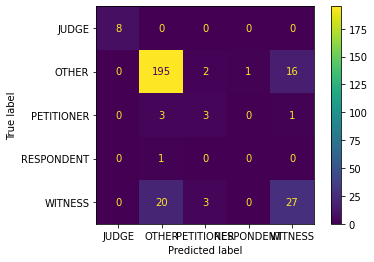

In [33]:
get_confusion_matrix(pred = all_labels_compare["pred"], true = all_labels_compare["true"], cat="natural_person")

## Analysis
crfsuirte provides two functions to analyse the quality of mashine learning.<br>
<b>print_transitions</b> shows which labels are often mixed with each other. <br>
<b>print_state_features</b> shows "typical" features of each label.

In [34]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s \t->\t %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(10))

Top likely transitions:
B-COURT 	->	 I-COURT 6.634040
I-ORG  	->	 I-ORG   6.604673
B-ORG  	->	 I-ORG   6.581671
I-PROVISION 	->	 I-PROVISION 6.508698
B-CASE_NUMBER 	->	 I-CASE_NUMBER 6.089499
B-RESPONDENT 	->	 I-RESPONDENT 6.088118
B-PROVISION 	->	 I-PROVISION 6.055514
B-JUDGE 	->	 I-JUDGE 6.051411
I-COURT 	->	 I-COURT 5.929151
I-RESPONDENT 	->	 I-RESPONDENT 5.891065


In [35]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(10))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-10:])

Top positive:
5.912660 B-JUDGE  -1:word.lower():justice
5.840469 B-ORG    word.lower():parliament
5.659227 B-STATUTE word.lower():constitution
5.058730 B-PETITIONER -1:word.lower():appellant
5.020820 B-WITNESS -1:word.lower():witness
4.942253 B-GPE    -1:word.lower():village
4.599063 o        BOS
4.479745 B-OTHER_PERSON -1:word.lower():mr.
4.363304 B-RESPONDENT -1:word.lower():respondent
4.334479 B-STATUTE word[-2:]:PC

Top negative:
-2.486915 I-PRECEDENT -1:word.lower():]
-2.493765 o        word.lower():parliament
-2.562522 o        -1:word.lower():smt.
-2.668181 o        -1:word.lower():ltd
-2.698582 o        -1:word.lower():mr.
-2.867852 o        word[-3:]:lal
-3.076056 o        -1:word.lower():dr.
-3.097427 o        +1:word.lower():s/o
-3.284672 o        word[-2:]:ah
-5.113884 B-DATE   word.isdigit()


## Visualization with SpaCy

In [3]:
import spacy
from spacy import displacy
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA
from spacy.tokens import Doc

2023-03-22 15:08:48.242663: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 15:08:48.602907: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-22 15:08:48.602927: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-22 15:08:50.057505: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
df_dev = pd.read_csv("transitional_data/tagged_dev_filled.csv", keep_default_na=False)

In [15]:
print(df_dev.groupby("SentenceNR").get_group(0)["Label"].tolist())

['o', 'o', 'o', 'B-STATUTE', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'o', 'B-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'o', 'B-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'I-PRECEDENT', 'o', 'o', 'o', 'o', 'o', 'o', 'o']


In [38]:
sents20 = []
labels20 = []
for i in range(20):
    
    sent = df_dev.groupby("SentenceNR").get_group(i)["Token"].tolist()
    sent.append("\n")
    sents20 += sent
    
    label = df_dev.groupby("SentenceNR").get_group(i)["Label"].tolist()
    label.append("o")
    labels20 += label

In [39]:
len(sents) == len(labels)

True

In [40]:
labels_new = []
for i in labels20:
    if i != "o":
        labels_new.append(i)
    else:
        labels_new.append("O")

In [42]:
nlp = spacy.load("en_core_web_sm")
doc = Doc(nlp.vocab, words=sents20, ents = labels_new)

In [43]:
colors = {'COURT': "#bbabf2", 'PETITIONER': "#f570ea", "RESPONDENT": "#cdee81", 'JUDGE': "#fdd8a5",
          "LAWYER": "#f9d380", 'WITNESS': "violet", "STATUTE": "#faea99", "PROVISION": "yellow",
          'CASE_NUMBER': "#fbb1cf", "PRECEDENT": "#fad6d6", 'DATE': "#b1ecf7", 'OTHER_PERSON': "#b0f6a2",
          'ORG':'#a57db5','GPE':'#7fdbd4'}

In [44]:
options = {"colors": colors}
displacy.serve(doc, style='ent', options=options)

/home/luxinyao/.local/lib/python3.10/site-packages/spacy/displacy/__init__.py:108: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'ent' visualizer
Serving on http://0.0.0.0:5000 ...



127.0.0.1 - - [22/Mar/2023 15:22:09] "GET / HTTP/1.1" 200 18762


Shutting down server on port 5000.
